# Yelp Review Dataset - Comprehensive EDA and Data Cleaning
**Author:** Ben

**Project:** Capstone - Star Rating Prediction from Review Text

**Objective:** Perform exploratory data analysis, clean the dataset, and prepare train/test splits for modeling

## 1. Setup and Data Loading

In [42]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tarfile
import os
import json
from datetime import datetime
import warnings
from sklearn.model_selection import train_test_split

warnings.filterwarnings('ignore')

# Set visualization defaults
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

# Create output directory for plots
os.makedirs('../Outputs/Plots', exist_ok=True)
os.makedirs('../Data/Processed', exist_ok=True)

print("✓ Libraries imported successfully")

✓ Libraries imported successfully


In [43]:
# Extract JSON files from tar if they don't exist
tar_path = '../Data/Raw/yelp_dataset.tar'
raw_folder = '../Data/Raw/'
json_files = [
    'yelp_academic_dataset_business.json',
    'yelp_academic_dataset_checkin.json',
    'yelp_academic_dataset_review.json',
    'yelp_academic_dataset_tip.json',
    'yelp_academic_dataset_user.json'
]

# Check which files need to be extracted
files_to_extract = [f for f in json_files if not os.path.exists(os.path.join(raw_folder, f))]

if files_to_extract:
    # List all files in the tar archive
    with tarfile.open(tar_path, 'r') as tar:
        print("Files in the tar archive:")
        for member in tar.getmembers():
            print(f"  - {member.name} ({member.size / 1024 / 1024:.1f} MB)")
    print(f"\nExtracting {len(files_to_extract)} JSON files from tar archive...")
    with tarfile.open(tar_path, 'r') as tar:
        for file in files_to_extract:
            print(f"  Extracting {file}...")
            tar.extract(file, path=raw_folder)
    print("✓ Extraction complete!")
else:
    print("✓ All JSON files already exist in the raw folder")

✓ All JSON files already exist in the raw folder


In [44]:
# Load datasets
data_path = '../Data/Raw/'

print("Loading datasets... this may take a while\n")

print("Loading business data...")
business_df = pd.read_json(f'{data_path}yelp_academic_dataset_business.json', lines=True)
print(f"✓ business_df: {len(business_df):,} rows")

print("\nLoading review data (this is BIG - 5GB)...")
review_df = pd.read_json(f'{data_path}yelp_academic_dataset_review.json', lines=True)
print(f"✓ review_df: {len(review_df):,} rows")

print("\nAll datasets loaded!")

Loading datasets... this may take a while

Loading business data...
✓ business_df: 150,346 rows

Loading review data (this is BIG - 5GB)...
✓ review_df: 6,990,280 rows

All datasets loaded!


In [45]:
# Merge review and business data
print("Merging review and business data...")
merged_df = pd.merge(review_df, business_df, on='business_id', how='left')
merged_df = merged_df.rename(columns={'stars_x': 'stars'}).drop(columns=['stars_y'])

print(f"✓ Merged dataset: {merged_df.shape[0]:,} rows × {merged_df.shape[1]} columns")
print(f"\nColumns: {list(merged_df.columns)}")

# Free up memory
del review_df
del business_df

Merging review and business data...
✓ Merged dataset: 6,990,280 rows × 21 columns

Columns: ['review_id', 'user_id', 'business_id', 'stars', 'useful', 'funny', 'cool', 'text', 'date', 'name', 'address', 'city', 'state', 'postal_code', 'latitude', 'longitude', 'review_count', 'is_open', 'attributes', 'categories', 'hours']


## 2. Initial Data Assessment

In [46]:
# Dataset overview
print("=" * 80)
print("DATASET OVERVIEW")
print("=" * 80)
print(f"\nShape: {merged_df.shape[0]:,} rows × {merged_df.shape[1]} columns")
print(f"Memory usage: {merged_df.memory_usage(deep=True).sum() / 1024**3:.2f} GB")
print(f"\nData types:")
print(merged_df.dtypes.value_counts())

DATASET OVERVIEW

Shape: 6,990,280 rows × 21 columns
Memory usage: 13.53 GB

Data types:
object            12
int64              6
float64            2
datetime64[ns]     1
Name: count, dtype: int64


In [47]:
# Missing values analysis
print("\n" + "=" * 80)
print("MISSING VALUES ANALYSIS")
print("=" * 80)

missing_data = pd.DataFrame({
    'Column': merged_df.columns,
    'Missing_Count': merged_df.isnull().sum(),
    'Missing_Percentage': (merged_df.isnull().sum() / len(merged_df) * 100).round(2)
}).sort_values('Missing_Count', ascending=False)

missing_data = missing_data[missing_data['Missing_Count'] > 0]
print(missing_data.to_string(index=False))

if len(missing_data) == 0:
    print("\n✓ No missing values found!")


MISSING VALUES ANALYSIS
    Column  Missing_Count  Missing_Percentage
     hours         398286                5.70
attributes         183723                2.63
categories            689                0.01


In [48]:
# Check for duplicates
print("\n" + "=" * 80)
print("DUPLICATE ANALYSIS")
print("=" * 80)

duplicate_reviews = merged_df.duplicated(subset=['review_id']).sum()
print(f"Duplicate review_ids: {duplicate_reviews:,}")

# Check for duplicate text from same user to same business
duplicate_content = merged_df.duplicated(subset=['user_id', 'business_id', 'text']).sum()
print(f"Duplicate reviews (same user, business, text): {duplicate_content:,}")


DUPLICATE ANALYSIS
Duplicate review_ids: 0
Duplicate reviews (same user, business, text): 12,627


In [49]:
# Basic statistics for numerical columns
print("\n" + "=" * 80)
print("NUMERICAL FEATURES STATISTICS")
print("=" * 80)

numerical_cols = ['stars', 'useful', 'funny', 'cool', 'review_count', 'latitude', 'longitude', 'is_open']
print(merged_df[numerical_cols].describe())


NUMERICAL FEATURES STATISTICS
              stars        useful         funny          cool  review_count  \
count  6.990280e+06  6.990280e+06  6.990280e+06  6.990280e+06  6.990280e+06   
mean   3.748584e+00  1.184609e+00  3.265596e-01  4.986175e-01  3.691714e+02   
std    1.478705e+00  3.253767e+00  1.688729e+00  2.172460e+00  7.360792e+02   
min    1.000000e+00 -1.000000e+00 -1.000000e+00 -1.000000e+00  5.000000e+00   
25%    3.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  4.300000e+01   
50%    4.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  1.350000e+02   
75%    5.000000e+00  1.000000e+00  0.000000e+00  0.000000e+00  3.640000e+02   
max    5.000000e+00  1.182000e+03  7.920000e+02  4.040000e+02  7.568000e+03   

           latitude     longitude       is_open  
count  6.990280e+06  6.990280e+06  6.990280e+06  
mean   3.594839e+01 -8.972830e+01  8.284695e-01  
std    5.347206e+00  1.488738e+01  3.769719e-01  
min    2.755513e+01 -1.200951e+02  0.000000e+00  
25%    

## 3. Target Variable Analysis

TARGET VARIABLE (STARS) DISTRIBUTION
 Stars   Count  Percentage
     1 1069561       15.30
     2  544240        7.79
     3  691934        9.90
     4 1452918       20.78
     5 3231627       46.23


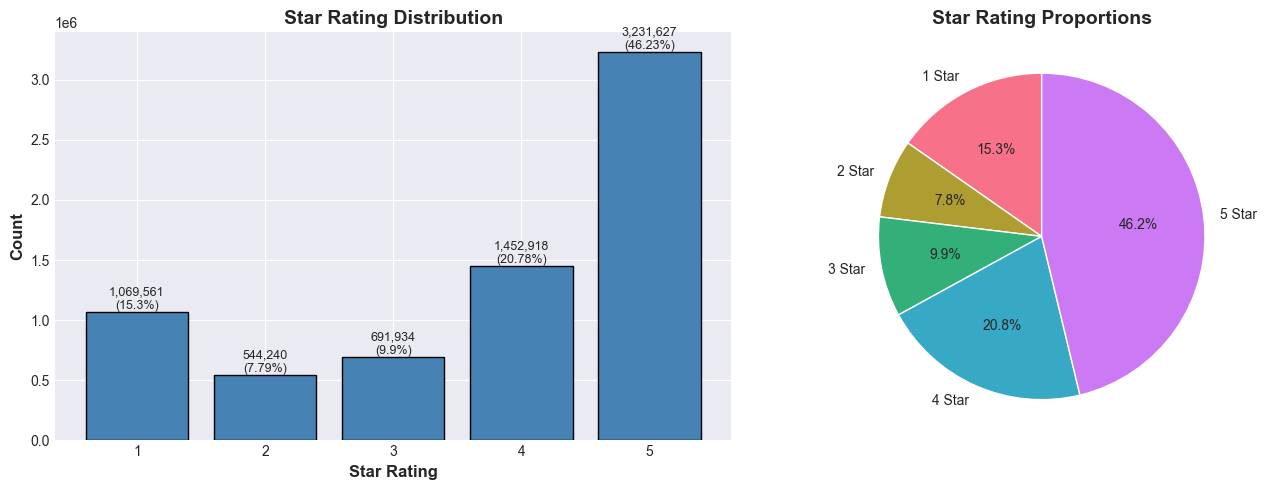


✓ Plot saved: 01_star_distribution.png


In [50]:
# Star rating distribution
print("=" * 80)
print("TARGET VARIABLE (STARS) DISTRIBUTION")
print("=" * 80)

star_counts = merged_df['stars'].value_counts().sort_index()
star_pcts = (star_counts / len(merged_df) * 100).round(2)

star_dist = pd.DataFrame({
    'Stars': star_counts.index,
    'Count': star_counts.values,
    'Percentage': star_pcts.values
})
print(star_dist.to_string(index=False))

# Visualize distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Bar plot
axes[0].bar(star_counts.index, star_counts.values, color='steelblue', edgecolor='black')
axes[0].set_xlabel('Star Rating', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Count', fontsize=12, fontweight='bold')
axes[0].set_title('Star Rating Distribution', fontsize=14, fontweight='bold')
axes[0].set_xticks([1, 2, 3, 4, 5])
for i, (star, count) in enumerate(zip(star_counts.index, star_counts.values)):
    axes[0].text(star, count, f'{count:,}\n({star_pcts.values[i]}%)', 
                ha='center', va='bottom', fontsize=9)

# Pie chart
axes[1].pie(star_counts.values, labels=[f'{int(s)} Star' for s in star_counts.index], 
           autopct='%1.1f%%', startangle=90, colors=sns.color_palette('husl', 5))
axes[1].set_title('Star Rating Proportions', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig('../Outputs/Plots/01_star_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n✓ Plot saved: 01_star_distribution.png")

In [51]:
# Class imbalance analysis
print("\n" + "=" * 80)
print("CLASS IMBALANCE ANALYSIS")
print("=" * 80)

# Calculate class weights for imbalanced learning
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight('balanced', 
                                     classes=np.unique(merged_df['stars']), 
                                     y=merged_df['stars'])
class_weight_dict = dict(zip(np.unique(merged_df['stars']), class_weights))

print("\nClass weights for balanced training:")
for star, weight in class_weight_dict.items():
    print(f"  {int(star)} star: {weight:.3f}")

# Calculate imbalance ratio
max_class = star_counts.max()
min_class = star_counts.min()
imbalance_ratio = max_class / min_class
print(f"\nImbalance ratio (max/min): {imbalance_ratio:.2f}:1")

if imbalance_ratio > 3:
    print("⚠️  Significant class imbalance detected!")
    print("   Recommendations: Use stratified sampling, class weights, or SMOTE")
else:
    print("✓ Class distribution is relatively balanced")


CLASS IMBALANCE ANALYSIS

Class weights for balanced training:
  1 star: 1.307
  2 star: 2.569
  3 star: 2.021
  4 star: 0.962
  5 star: 0.433

Imbalance ratio (max/min): 5.94:1
⚠️  Significant class imbalance detected!
   Recommendations: Use stratified sampling, class weights, or SMOTE


## 4. Text Data Analysis

In [52]:
# Text preprocessing and length analysis
print("=" * 80)
print("TEXT DATA ANALYSIS")
print("=" * 80)

# Check for null/empty text
null_text = merged_df['text'].isnull().sum()
empty_text = (merged_df['text'].str.strip() == '').sum()
print(f"Null text reviews: {null_text:,}")
print(f"Empty text reviews: {empty_text:,}")

# Calculate text lengths
print("\nCalculating text lengths...")
merged_df['char_count'] = merged_df['text'].str.len()
merged_df['word_count'] = merged_df['text'].str.split().str.len()

print("\nText length statistics:")
print(merged_df[['char_count', 'word_count']].describe())

TEXT DATA ANALYSIS
Null text reviews: 0
Empty text reviews: 0

Calculating text lengths...

Text length statistics:
         char_count    word_count
count  6.990280e+06  6.990280e+06
mean   5.677644e+02  1.047763e+02
std    5.272578e+02  9.792227e+01
min    1.000000e+00  1.000000e+00
25%    2.290000e+02  4.200000e+01
50%    4.060000e+02  7.500000e+01
75%    7.200000e+02  1.330000e+02
max    5.000000e+03  1.070000e+03


In [53]:
# Categorize reviews by length
def categorize_length(word_count):
    if word_count < 50:
        return 'Very Short (<50)'
    elif word_count < 150:
        return 'Short (50-150)'
    elif word_count < 500:
        return 'Medium (150-500)'
    else:
        return 'Long (>500)'

merged_df['length_category'] = merged_df['word_count'].apply(categorize_length)

length_dist = merged_df['length_category'].value_counts()
length_pct = (length_dist / len(merged_df) * 100).round(2)

print("\nReview length distribution:")
for cat in ['Very Short (<50)', 'Short (50-150)', 'Medium (150-500)', 'Long (>500)']:
    if cat in length_dist.index:
        print(f"  {cat}: {length_dist[cat]:,} ({length_pct[cat]}%)")


Review length distribution:
  Very Short (<50): 2,221,003 (31.77%)
  Short (50-150): 3,313,223 (47.4%)
  Medium (150-500): 1,390,964 (19.9%)
  Long (>500): 65,090 (0.93%)


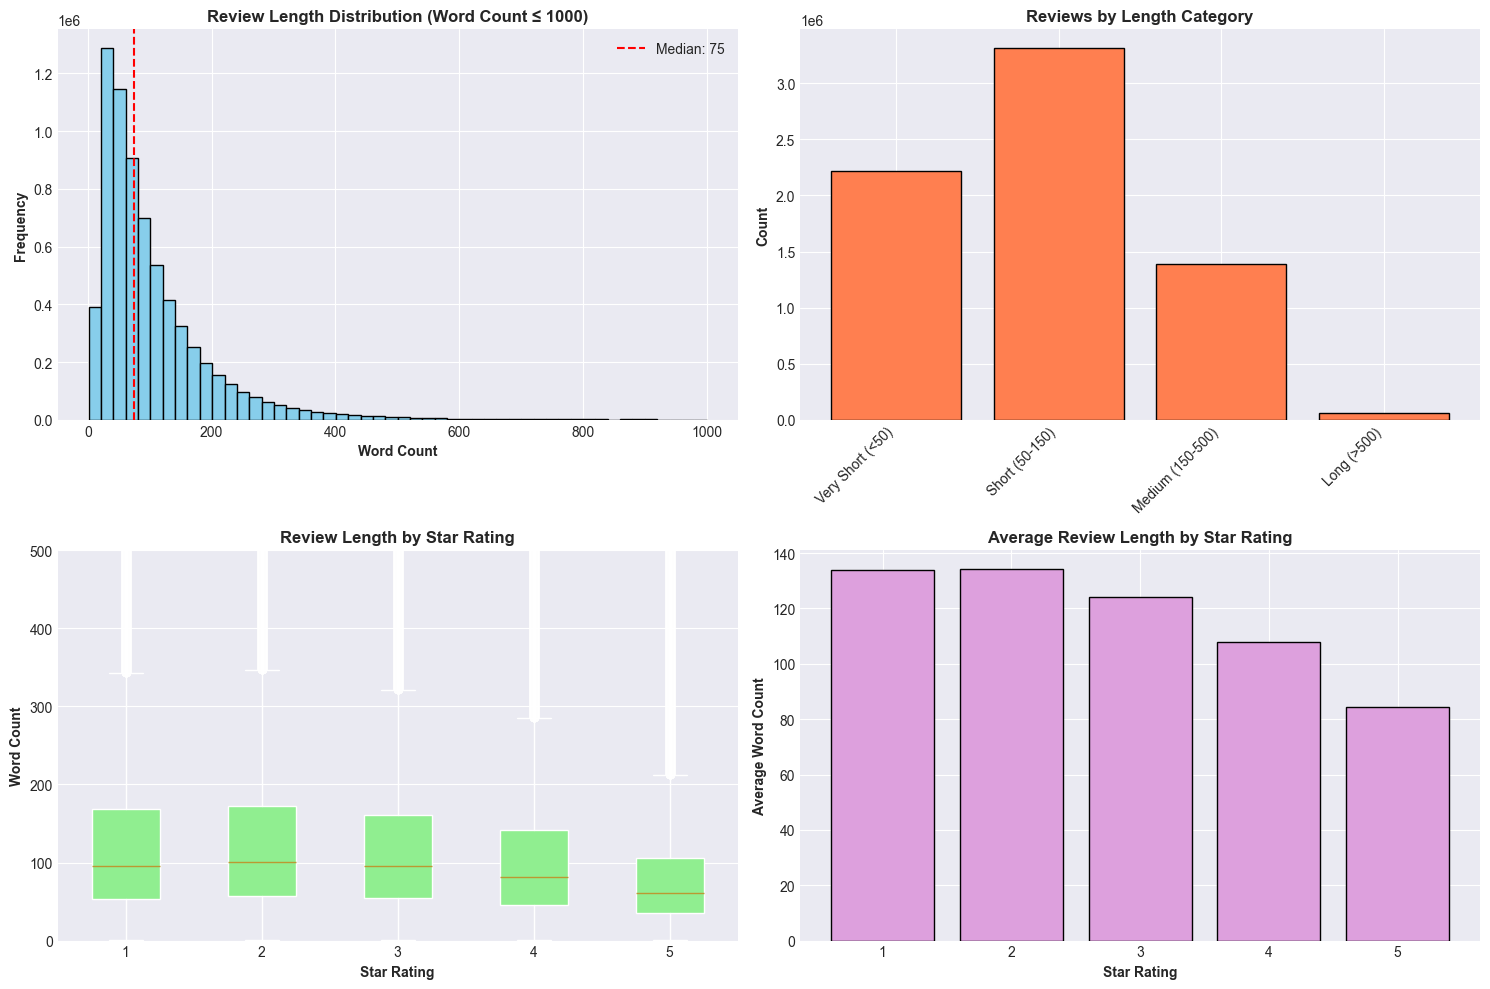

✓ Plot saved: 02_text_length_analysis.png


In [54]:
# Visualize text length distributions
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Histogram of word counts (capped at 1000 for visibility)
word_counts_capped = merged_df[merged_df['word_count'] <= 1000]['word_count']
axes[0, 0].hist(word_counts_capped, bins=50, color='skyblue', edgecolor='black')
axes[0, 0].set_xlabel('Word Count', fontweight='bold')
axes[0, 0].set_ylabel('Frequency', fontweight='bold')
axes[0, 0].set_title('Review Length Distribution (Word Count ≤ 1000)', fontweight='bold')
axes[0, 0].axvline(merged_df['word_count'].median(), color='red', 
                   linestyle='--', label=f'Median: {merged_df["word_count"].median():.0f}')
axes[0, 0].legend()

# Length category bar chart
cat_order = ['Very Short (<50)', 'Short (50-150)', 'Medium (150-500)', 'Long (>500)']
length_dist_ordered = length_dist.reindex(cat_order)
axes[0, 1].bar(range(len(cat_order)), length_dist_ordered.values, 
               color='coral', edgecolor='black')
axes[0, 1].set_xticks(range(len(cat_order)))
axes[0, 1].set_xticklabels(cat_order, rotation=45, ha='right')
axes[0, 1].set_ylabel('Count', fontweight='bold')
axes[0, 1].set_title('Reviews by Length Category', fontweight='bold')

# Box plot of word count by star rating
data_for_box = [merged_df[merged_df['stars'] == s]['word_count'] for s in [1, 2, 3, 4, 5]]
bp = axes[1, 0].boxplot(data_for_box, labels=[1, 2, 3, 4, 5], patch_artist=True)
for patch in bp['boxes']:
    patch.set_facecolor('lightgreen')
axes[1, 0].set_xlabel('Star Rating', fontweight='bold')
axes[1, 0].set_ylabel('Word Count', fontweight='bold')
axes[1, 0].set_title('Review Length by Star Rating', fontweight='bold')
axes[1, 0].set_ylim(0, 500)

# Average word count by star rating
avg_words_by_star = merged_df.groupby('stars')['word_count'].mean()
axes[1, 1].bar(avg_words_by_star.index, avg_words_by_star.values, 
               color='plum', edgecolor='black')
axes[1, 1].set_xlabel('Star Rating', fontweight='bold')
axes[1, 1].set_ylabel('Average Word Count', fontweight='bold')
axes[1, 1].set_title('Average Review Length by Star Rating', fontweight='bold')
axes[1, 1].set_xticks([1, 2, 3, 4, 5])

plt.tight_layout()
plt.savefig('../Outputs/Plots/02_text_length_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Plot saved: 02_text_length_analysis.png")

In [55]:
# Sample reviews from each star rating
print("\n" + "=" * 80)
print("SAMPLE REVIEWS BY STAR RATING")
print("=" * 80)

for star in [1, 2, 3, 4, 5]:
    print(f"\n{'='*40}")
    print(f"{star}-STAR REVIEW SAMPLE")
    print('='*40)
    sample = merged_df[merged_df['stars'] == star].sample(1).iloc[0]
    print(f"Words: {sample['word_count']}")
    print(f"Text: {sample['text'][:300]}...")
    print()


SAMPLE REVIEWS BY STAR RATING

1-STAR REVIEW SAMPLE
Words: 78
Text: If I could give this restaurant zero stars, I would enthusiastically do so.  I've eaten at all sorts of eateries over the years, and this may be the WORST restaurant at which I've ever dined.  My food did not come out hot and was not particularly appetizing.  In addition, the management was less tha...


2-STAR REVIEW SAMPLE
Words: 52
Text: Ordered to-go. Our receipt says we ordered at 1:14pm... it is now 2:07pm

We also noticed minutes before we got our food, that another person that ordered after us picked up their food. Funny how our bag looked identical to the one the other customer picked up. 

Oh well... it was good....


3-STAR REVIEW SAMPLE
Words: 59
Text: Husband got meat lovers pizza, it was huge and looked amazing...he loved it. I got fish and chips, the fish was frozen not fresh.  I could have gotten the same thing actually better if I went to the grocery store and bought some Gordon's frozen filets.  The 

In [56]:
# Extreme length examples
print("\n" + "=" * 80)
print("EXTREME LENGTH EXAMPLES")
print("=" * 80)

# Very short reviews
print("\nVERY SHORT REVIEWS (<20 words):")
short_reviews = merged_df[merged_df['word_count'] < 20].sample(min(5, len(merged_df[merged_df['word_count'] < 20])))
for idx, row in short_reviews.iterrows():
    print(f"  {int(row['stars'])} stars ({row['word_count']} words): {row['text']}")

# Very long reviews
print("\nVERY LONG REVIEWS (>500 words):")
long_reviews = merged_df[merged_df['word_count'] > 500].sample(min(3, len(merged_df[merged_df['word_count'] > 500])))
for idx, row in long_reviews.iterrows():
    print(f"  {int(row['stars'])} stars ({row['word_count']} words): {row['text'][:200]}...")


EXTREME LENGTH EXAMPLES

VERY SHORT REVIEWS (<20 words):
  3 stars (12 words): Good food. Decent prices for the airport. Terribly slow service!!! Seemed understaffed.
  5 stars (18 words): Very authentic hispanic style, tasty and flavorful. Prices are not bad for portions and Margaritas are awesomely good.
  5 stars (15 words): sexy and hilarious!  Chris Lane is a fantastic host.  The act was sophisticated and polished.
  5 stars (18 words): This was my first try and the sandwich was very good. When you walk in it smells amazing!
  5 stars (15 words): Honest, FAST and reliable.  Just found my new mechanics! Go here if you are searching!!!

VERY LONG REVIEWS (>500 words):
  5 stars (641 words): Among foods that connect us with our ancestors, the humble chickpea (a.k.a. garbanzo bean) has been cultivated and consumed since the beginning of agriculture. I once thought this fat orb of protein a...
  5 stars (526 words): This is one of three Honduran restaurants I know of in Indianapolis. 

## 5. Temporal Analysis

In [57]:
# Convert date to datetime
print("=" * 80)
print("TEMPORAL ANALYSIS")
print("=" * 80)

print("\nConverting date column to datetime...")
merged_df['date'] = pd.to_datetime(merged_df['date'])

# Date range
print(f"\nDate range:")
print(f"  Earliest review: {merged_df['date'].min()}")
print(f"  Latest review: {merged_df['date'].max()}")
print(f"  Span: {(merged_df['date'].max() - merged_df['date'].min()).days} days")

# Extract temporal features
merged_df['year'] = merged_df['date'].dt.year
merged_df['month'] = merged_df['date'].dt.month
merged_df['day_of_week'] = merged_df['date'].dt.dayofweek

TEMPORAL ANALYSIS

Converting date column to datetime...

Date range:
  Earliest review: 2005-02-16 03:23:22
  Latest review: 2022-01-19 19:48:45
  Span: 6181 days


In [58]:
# Reviews over time
print("\nReviews per year:")
reviews_per_year = merged_df['year'].value_counts().sort_index()
for year, count in reviews_per_year.items():
    print(f"  {year}: {count:,}")


Reviews per year:
  2005: 854
  2006: 3,853
  2007: 15,363
  2008: 48,226
  2009: 74,387
  2010: 138,587
  2011: 230,813
  2012: 286,570
  2013: 383,950
  2014: 522,275
  2015: 688,415
  2016: 758,882
  2017: 820,048
  2018: 906,362
  2019: 907,284
  2020: 554,557
  2021: 618,189
  2022: 31,665


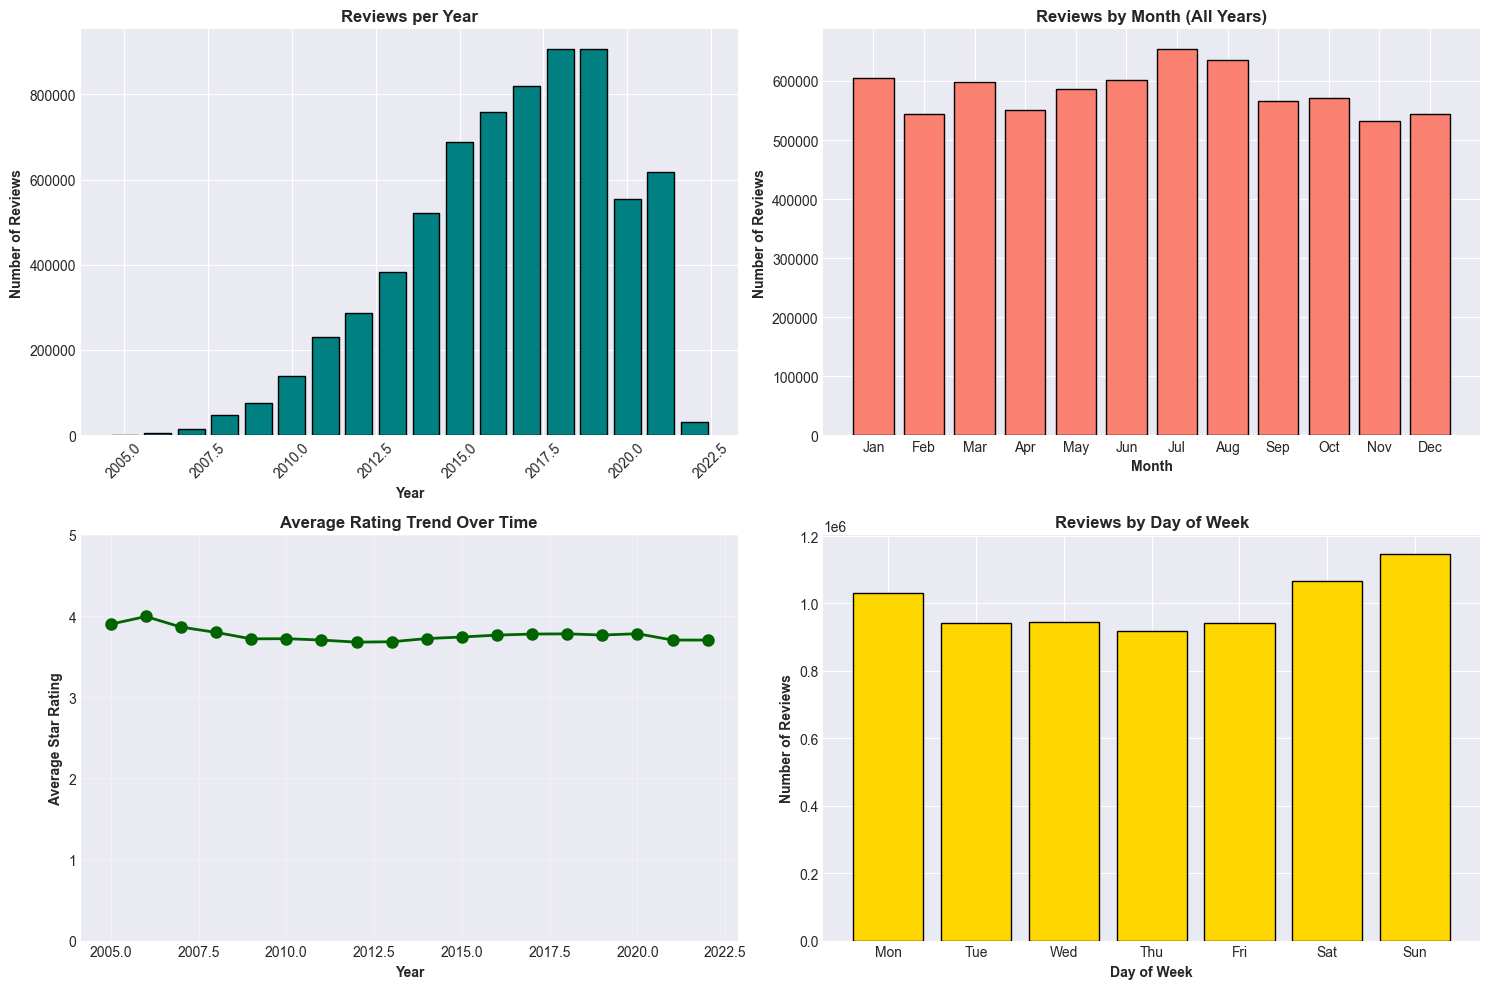

✓ Plot saved: 03_temporal_analysis.png


In [59]:
# Visualize temporal patterns
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Reviews per year
axes[0, 0].bar(reviews_per_year.index, reviews_per_year.values, color='teal', edgecolor='black')
axes[0, 0].set_xlabel('Year', fontweight='bold')
axes[0, 0].set_ylabel('Number of Reviews', fontweight='bold')
axes[0, 0].set_title('Reviews per Year', fontweight='bold')
axes[0, 0].tick_params(axis='x', rotation=45)

# Reviews per month (aggregated across all years)
reviews_per_month = merged_df['month'].value_counts().sort_index()
month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
               'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
axes[0, 1].bar(reviews_per_month.index, reviews_per_month.values, color='salmon', edgecolor='black')
axes[0, 1].set_xticks(range(1, 13))
axes[0, 1].set_xticklabels(month_names)
axes[0, 1].set_xlabel('Month', fontweight='bold')
axes[0, 1].set_ylabel('Number of Reviews', fontweight='bold')
axes[0, 1].set_title('Reviews by Month (All Years)', fontweight='bold')

# Average rating over time
avg_rating_by_year = merged_df.groupby('year')['stars'].mean()
axes[1, 0].plot(avg_rating_by_year.index, avg_rating_by_year.values, 
                marker='o', linewidth=2, markersize=8, color='darkgreen')
axes[1, 0].set_xlabel('Year', fontweight='bold')
axes[1, 0].set_ylabel('Average Star Rating', fontweight='bold')
axes[1, 0].set_title('Average Rating Trend Over Time', fontweight='bold')
axes[1, 0].set_ylim(0, 5)
axes[1, 0].grid(True, alpha=0.3)

# Day of week analysis
dow_names = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
reviews_per_dow = merged_df['day_of_week'].value_counts().sort_index()
axes[1, 1].bar(reviews_per_dow.index, reviews_per_dow.values, color='gold', edgecolor='black')
axes[1, 1].set_xticks(range(7))
axes[1, 1].set_xticklabels(dow_names)
axes[1, 1].set_xlabel('Day of Week', fontweight='bold')
axes[1, 1].set_ylabel('Number of Reviews', fontweight='bold')
axes[1, 1].set_title('Reviews by Day of Week', fontweight='bold')

plt.tight_layout()
plt.savefig('../Outputs/Plots/03_temporal_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Plot saved: 03_temporal_analysis.png")

## 6. Business Metadata Analysis

In [60]:
# Categories analysis
print("=" * 80)
print("BUSINESS CATEGORIES ANALYSIS")
print("=" * 80)

# Parse categories (comma-separated string to list)
print("\nParsing categories...")
merged_df['categories_list'] = merged_df['categories'].fillna('').str.split(', ')

# Flatten all categories
from collections import Counter
all_categories = [cat for cats in merged_df['categories_list'] if cats != [''] for cat in cats]
category_counts = Counter(all_categories)

print(f"\nTotal unique categories: {len(category_counts)}")
print(f"\nTop 20 business categories:")
top_20_cats = dict(category_counts.most_common(20))
for i, (cat, count) in enumerate(top_20_cats.items(), 1):
    print(f"  {i:2d}. {cat:30s} {count:,}")

BUSINESS CATEGORIES ANALYSIS

Parsing categories...

Total unique categories: 1311

Top 20 business categories:
   1. Restaurants                    4,724,471
   2. Food                           1,813,593
   3. Nightlife                      1,539,757
   4. Bars                           1,455,553
   5. American (Traditional)         1,011,646
   6. American (New)                 984,540
   7. Breakfast & Brunch             867,430
   8. Sandwiches                     691,864
   9. Seafood                        620,247
  10. Event Planning & Services      609,553
  11. Shopping                       523,254
  12. Pizza                          475,819
  13. Burgers                        445,895
  14. Coffee & Tea                   442,348
  15. Italian                        439,358
  16. Mexican                        431,020
  17. Beauty & Spas                  370,121
  18. Arts & Entertainment           345,059
  19. Cocktail Bars                  339,102
  20. Salad            

In [61]:
# Calculate average rating by top categories
print("\n" + "=" * 80)
print("AVERAGE RATING BY CATEGORY")
print("=" * 80)

# For each of top 10 categories, find average rating
top_10_cats = list(dict(category_counts.most_common(10)).keys())
cat_ratings = {}

for cat in top_10_cats:
    mask = merged_df['categories_list'].apply(lambda x: cat in x if x != [''] else False)
    cat_ratings[cat] = merged_df[mask]['stars'].mean()

cat_ratings_df = pd.DataFrame(list(cat_ratings.items()), 
                              columns=['Category', 'Avg_Rating']).sort_values('Avg_Rating', ascending=False)
print(cat_ratings_df.to_string(index=False))


AVERAGE RATING BY CATEGORY
                 Category  Avg_Rating
                     Food    3.894676
       Breakfast & Brunch    3.879319
                  Seafood    3.851529
               Sandwiches    3.851399
           American (New)    3.841483
              Restaurants    3.793798
                     Bars    3.791957
                Nightlife    3.791832
Event Planning & Services    3.690517
   American (Traditional)    3.668343


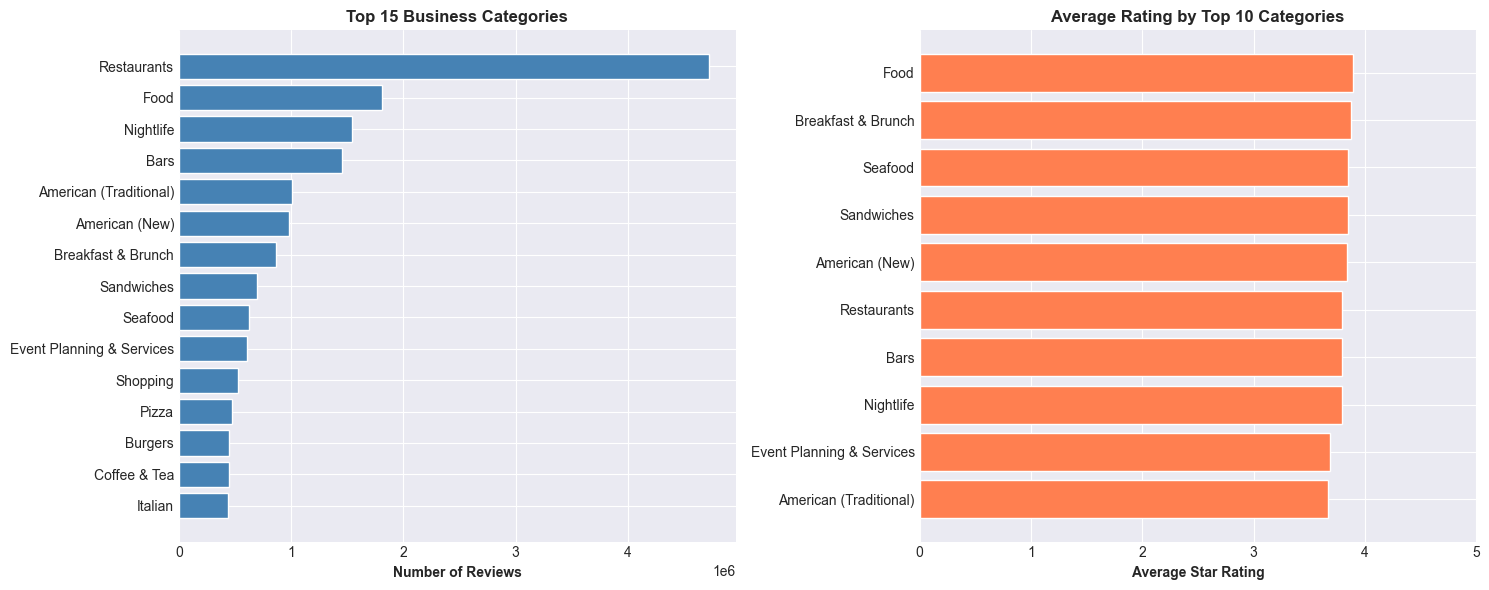

✓ Plot saved: 04_category_analysis.png


In [62]:
# Visualize categories
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Top 15 categories by count
top_15 = dict(category_counts.most_common(15))
axes[0].barh(list(top_15.keys())[::-1], list(top_15.values())[::-1], color='steelblue')
axes[0].set_xlabel('Number of Reviews', fontweight='bold')
axes[0].set_title('Top 15 Business Categories', fontweight='bold')

# Average rating by top 10 categories
axes[1].barh(cat_ratings_df['Category'][::-1], cat_ratings_df['Avg_Rating'][::-1], color='coral')
axes[1].set_xlabel('Average Star Rating', fontweight='bold')
axes[1].set_title('Average Rating by Top 10 Categories', fontweight='bold')
axes[1].set_xlim(0, 5)

plt.tight_layout()
plt.savefig('../Outputs/Plots/04_category_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Plot saved: 04_category_analysis.png")

In [63]:
# Location analysis
print("\n" + "=" * 80)
print("LOCATION ANALYSIS")
print("=" * 80)

# Check for missing lat/long
missing_coords = merged_df[['latitude', 'longitude']].isnull().sum()
print(f"\nMissing coordinates:")
print(f"  Latitude: {missing_coords['latitude']:,}")
print(f"  Longitude: {missing_coords['longitude']:,}")

# Top states
print("\nTop 15 states by review count:")
state_counts = merged_df['state'].value_counts().head(15)
for i, (state, count) in enumerate(state_counts.items(), 1):
    print(f"  {i:2d}. {state:5s} {count:,}")

# Top cities
print("\nTop 15 cities by review count:")
city_counts = merged_df['city'].value_counts().head(15)
for i, (city, count) in enumerate(city_counts.items(), 1):
    print(f"  {i:2d}. {city:30s} {count:,}")


LOCATION ANALYSIS

Missing coordinates:
  Latitude: 0
  Longitude: 0

Top 15 states by review count:
   1. PA    1,598,960
   2. FL    1,161,545
   3. LA    761,673
   4. TN    614,388
   5. MO    502,385
   6. IN    489,752
   7. AZ    431,708
   8. NV    430,678
   9. CA    348,856
  10. NJ    260,897
  11. ID    157,572
  12. AB    109,436
  13. DE    70,302
  14. IL    51,832
  15. MA    44

Top 15 cities by review count:
   1. Philadelphia                   967,552
   2. New Orleans                    635,364
   3. Tampa                          454,889
   4. Nashville                      451,571
   5. Tucson                         404,880
   6. Indianapolis                   361,489
   7. Reno                           351,573
   8. Santa Barbara                  269,630
   9. Saint Louis                    253,437
  10. Boise                          105,366
  11. Edmonton                       101,823
  12. Clearwater                     87,442
  13. Saint Petersburg        

In [64]:
# Average rating by location
print("\nAverage rating by top 10 states:")
top_10_states = state_counts.head(10).index
state_ratings = merged_df[merged_df['state'].isin(top_10_states)].groupby('state')['stars'].mean().sort_values(ascending=False)
for state, rating in state_ratings.items():
    print(f"  {state}: {rating:.2f}")


Average rating by top 10 states:
  CA: 3.96
  LA: 3.88
  IN: 3.79
  FL: 3.76
  TN: 3.76
  MO: 3.73
  NV: 3.73
  PA: 3.70
  AZ: 3.69
  NJ: 3.56


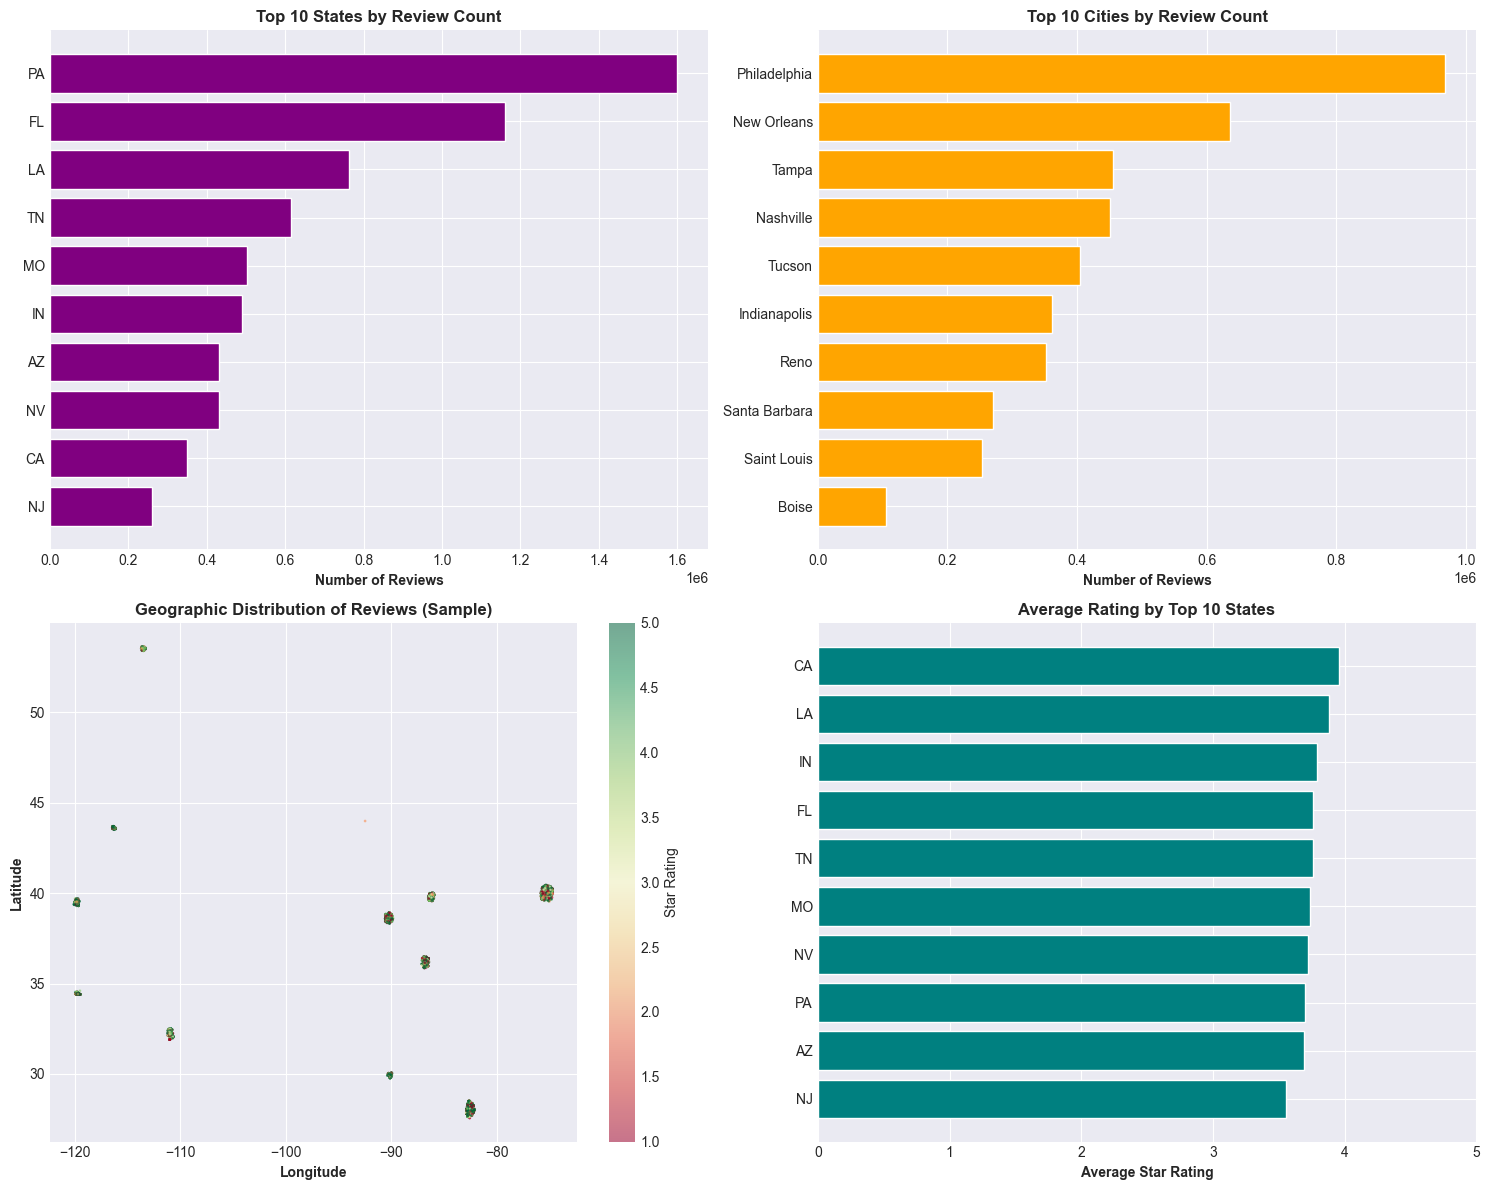

✓ Plot saved: 05_location_analysis.png


In [65]:
# Visualize location data
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Top 10 states
axes[0, 0].barh(state_counts.head(10).index[::-1], state_counts.head(10).values[::-1], color='purple')
axes[0, 0].set_xlabel('Number of Reviews', fontweight='bold')
axes[0, 0].set_title('Top 10 States by Review Count', fontweight='bold')

# Top 10 cities
axes[0, 1].barh(city_counts.head(10).index[::-1], city_counts.head(10).values[::-1], color='orange')
axes[0, 1].set_xlabel('Number of Reviews', fontweight='bold')
axes[0, 1].set_title('Top 10 Cities by Review Count', fontweight='bold')

# Geographic scatter (sample for speed)
sample_geo = merged_df.dropna(subset=['latitude', 'longitude']).sample(min(50000, len(merged_df)))
scatter = axes[1, 0].scatter(sample_geo['longitude'], sample_geo['latitude'], 
                            c=sample_geo['stars'], cmap='RdYlGn', 
                            alpha=0.5, s=1)
axes[1, 0].set_xlabel('Longitude', fontweight='bold')
axes[1, 0].set_ylabel('Latitude', fontweight='bold')
axes[1, 0].set_title('Geographic Distribution of Reviews (Sample)', fontweight='bold')
plt.colorbar(scatter, ax=axes[1, 0], label='Star Rating')

# Average rating by top 10 states
axes[1, 1].barh(state_ratings.index[::-1], state_ratings.values[::-1], color='teal')
axes[1, 1].set_xlabel('Average Star Rating', fontweight='bold')
axes[1, 1].set_title('Average Rating by Top 10 States', fontweight='bold')
axes[1, 1].set_xlim(0, 5)

plt.tight_layout()
plt.savefig('../Outputs/Plots/05_location_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Plot saved: 05_location_analysis.png")

In [66]:
# Business metrics analysis
print("\n" + "=" * 80)
print("BUSINESS METRICS ANALYSIS")
print("=" * 80)

print("\nBusiness review count statistics:")
print(merged_df['review_count'].describe())

# Open vs closed businesses
print("\nOpen vs Closed businesses:")
open_counts = merged_df['is_open'].value_counts()
for status, count in open_counts.items():
    status_name = 'Open' if status == 1 else 'Closed'
    print(f"  {status_name}: {count:,} ({count/len(merged_df)*100:.1f}%)")

# Average stars for open vs closed
print("\nAverage stars by business status:")
for status in [0, 1]:
    status_name = 'Open' if status == 1 else 'Closed'
    avg_stars = merged_df[merged_df['is_open'] == status]['stars'].mean()
    print(f"  {status_name}: {avg_stars:.2f}")


BUSINESS METRICS ANALYSIS

Business review count statistics:
count    6.990280e+06
mean     3.691714e+02
std      7.360792e+02
min      5.000000e+00
25%      4.300000e+01
50%      1.350000e+02
75%      3.640000e+02
max      7.568000e+03
Name: review_count, dtype: float64

Open vs Closed businesses:
  Open: 5,791,234 (82.8%)
  Closed: 1,199,046 (17.2%)

Average stars by business status:
  Closed: 3.62
  Open: 3.77


## 7. Review Engagement Metrics Analysis

In [67]:
# Engagement metrics analysis
print("=" * 80)
print("REVIEW ENGAGEMENT METRICS")
print("=" * 80)

engagement_cols = ['useful', 'funny', 'cool']

print("\nEngagement statistics:")
print(merged_df[engagement_cols].describe())

# Check for zero engagement
zero_engagement = (merged_df[engagement_cols] == 0).all(axis=1).sum()
print(f"\nReviews with zero engagement (no useful/funny/cool): {zero_engagement:,} ({zero_engagement/len(merged_df)*100:.1f}%)")

# Create total engagement score
merged_df['total_engagement'] = merged_df[engagement_cols].sum(axis=1)

REVIEW ENGAGEMENT METRICS

Engagement statistics:
             useful         funny          cool
count  6.990280e+06  6.990280e+06  6.990280e+06
mean   1.184609e+00  3.265596e-01  4.986175e-01
std    3.253767e+00  1.688729e+00  2.172460e+00
min   -1.000000e+00 -1.000000e+00 -1.000000e+00
25%    0.000000e+00  0.000000e+00  0.000000e+00
50%    0.000000e+00  0.000000e+00  0.000000e+00
75%    1.000000e+00  0.000000e+00  0.000000e+00
max    1.182000e+03  7.920000e+02  4.040000e+02

Reviews with zero engagement (no useful/funny/cool): 3,443,238 (49.3%)


In [68]:
# Correlation analysis
print("\n" + "=" * 80)
print("CORRELATION ANALYSIS")
print("=" * 80)

# Select numerical columns for correlation
corr_cols = ['stars', 'useful', 'funny', 'cool', 'word_count', 'review_count', 'is_open']
correlation_matrix = merged_df[corr_cols].corr()

print("\nCorrelation with star rating:")
star_corr = correlation_matrix['stars'].sort_values(ascending=False)
for col, corr in star_corr.items():
    if col != 'stars':
        print(f"  {col:20s}: {corr:+.3f}")


CORRELATION ANALYSIS

Correlation with star rating:
  review_count        : +0.078
  cool                : +0.069
  is_open             : +0.039
  funny               : -0.043
  useful              : -0.072
  word_count          : -0.202


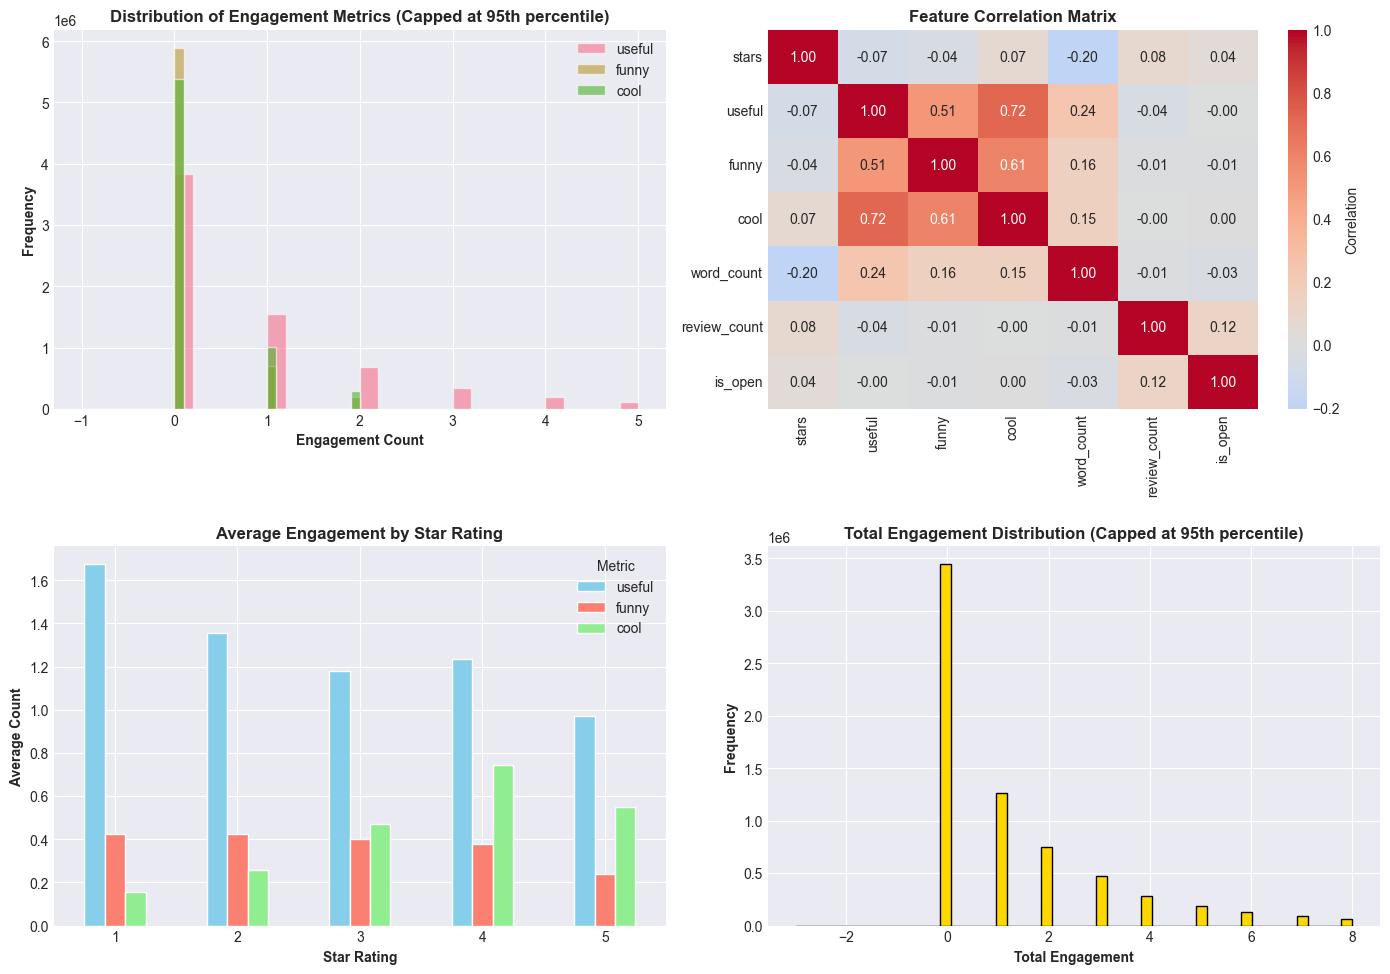

✓ Plot saved: 06_engagement_correlation.png


In [69]:
# Visualize engagement and correlations
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Distribution of engagement metrics
for i, metric in enumerate(['useful', 'funny', 'cool']):
    # Cap at 95th percentile for better visualization
    cap = merged_df[metric].quantile(0.95)
    data_capped = merged_df[merged_df[metric] <= cap][metric]
    axes[0, 0].hist(data_capped, bins=30, alpha=0.6, label=metric)

axes[0, 0].set_xlabel('Engagement Count', fontweight='bold')
axes[0, 0].set_ylabel('Frequency', fontweight='bold')
axes[0, 0].set_title('Distribution of Engagement Metrics (Capped at 95th percentile)', fontweight='bold')
axes[0, 0].legend()

# Correlation heatmap
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', 
            center=0, ax=axes[0, 1], cbar_kws={'label': 'Correlation'})
axes[0, 1].set_title('Feature Correlation Matrix', fontweight='bold')

# Engagement by star rating
engagement_by_star = merged_df.groupby('stars')[engagement_cols].mean()
engagement_by_star.plot(kind='bar', ax=axes[1, 0], color=['skyblue', 'salmon', 'lightgreen'])
axes[1, 0].set_xlabel('Star Rating', fontweight='bold')
axes[1, 0].set_ylabel('Average Count', fontweight='bold')
axes[1, 0].set_title('Average Engagement by Star Rating', fontweight='bold')
axes[1, 0].legend(title='Metric')
axes[1, 0].tick_params(axis='x', rotation=0)

# Total engagement distribution
total_eng_capped = merged_df[merged_df['total_engagement'] <= merged_df['total_engagement'].quantile(0.95)]['total_engagement']
axes[1, 1].hist(total_eng_capped, bins=50, color='gold', edgecolor='black')
axes[1, 1].set_xlabel('Total Engagement', fontweight='bold')
axes[1, 1].set_ylabel('Frequency', fontweight='bold')
axes[1, 1].set_title('Total Engagement Distribution (Capped at 95th percentile)', fontweight='bold')

plt.tight_layout()
plt.savefig('../Outputs/Plots/06_engagement_correlation.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Plot saved: 06_engagement_correlation.png")

## 8. User-Level Patterns

In [70]:
# User analysis
print("=" * 80)
print("USER-LEVEL ANALYSIS")
print("=" * 80)

unique_users = merged_df['user_id'].nunique()
print(f"\nTotal unique users: {unique_users:,}")

# Reviews per user
reviews_per_user = merged_df['user_id'].value_counts()
print(f"\nReviews per user statistics:")
print(reviews_per_user.describe())

# Power users
power_users = (reviews_per_user > 100).sum()
print(f"\nPower users (>100 reviews): {power_users:,} ({power_users/unique_users*100:.2f}% of users)")
print(f"Casual users (1-10 reviews): {(reviews_per_user <= 10).sum():,} ({(reviews_per_user <= 10).sum()/unique_users*100:.1f}% of users)")

USER-LEVEL ANALYSIS

Total unique users: 1,987,929

Reviews per user statistics:
count    1.987929e+06
mean     3.516363e+00
std      1.277088e+01
min      1.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      3.000000e+00
max      3.048000e+03
Name: count, dtype: float64

Power users (>100 reviews): 4,284 (0.22% of users)
Casual users (1-10 reviews): 1,884,678 (94.8% of users)


In [71]:
# Average stars by user review count
merged_df['user_review_count'] = merged_df.groupby('user_id')['user_id'].transform('count')

# Create user activity buckets
def user_activity_bucket(count):
    if count == 1:
        return '1 review'
    elif count <= 5:
        return '2-5 reviews'
    elif count <= 20:
        return '6-20 reviews'
    elif count <= 100:
        return '21-100 reviews'
    else:
        return '100+ reviews'

merged_df['user_activity'] = merged_df['user_review_count'].apply(user_activity_bucket)

print("\nAverage stars by user activity level:")
activity_order = ['1 review', '2-5 reviews', '6-20 reviews', '21-100 reviews', '100+ reviews']
avg_stars_by_activity = merged_df.groupby('user_activity')['stars'].mean().reindex(activity_order)
for activity, avg in avg_stars_by_activity.items():
    print(f"  {activity:20s}: {avg:.2f}")


Average stars by user activity level:
  1 review            : 3.51
  2-5 reviews         : 3.72
  6-20 reviews        : 3.80
  21-100 reviews      : 3.84
  100+ reviews        : 3.86


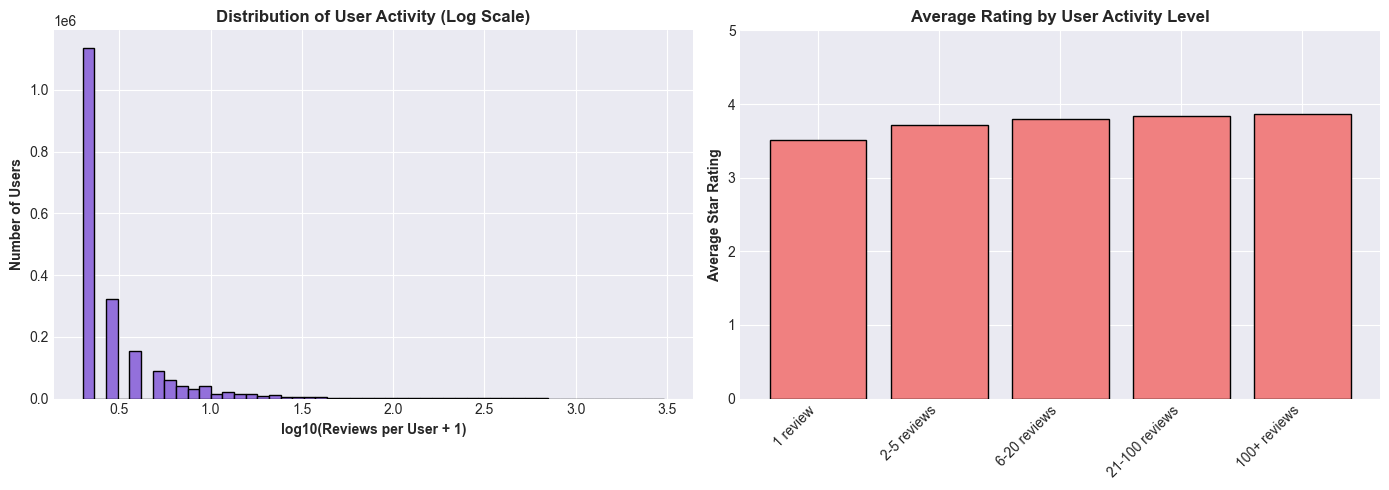

✓ Plot saved: 07_user_analysis.png


In [72]:
# Visualize user patterns
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Distribution of reviews per user (log scale)
axes[0].hist(np.log10(reviews_per_user.values + 1), bins=50, color='mediumpurple', edgecolor='black')
axes[0].set_xlabel('log10(Reviews per User + 1)', fontweight='bold')
axes[0].set_ylabel('Number of Users', fontweight='bold')
axes[0].set_title('Distribution of User Activity (Log Scale)', fontweight='bold')

# Average stars by user activity
axes[1].bar(range(len(activity_order)), avg_stars_by_activity.values, 
           color='lightcoral', edgecolor='black')
axes[1].set_xticks(range(len(activity_order)))
axes[1].set_xticklabels(activity_order, rotation=45, ha='right')
axes[1].set_ylabel('Average Star Rating', fontweight='bold')
axes[1].set_title('Average Rating by User Activity Level', fontweight='bold')
axes[1].set_ylim(0, 5)

plt.tight_layout()
plt.savefig('../Outputs/Plots/07_user_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Plot saved: 07_user_analysis.png")

## 9. Data Quality Issues

In [73]:
# Data quality checks
print("=" * 80)
print("DATA QUALITY ISSUES")
print("=" * 80)

issues = {}

# Missing text
missing_text = merged_df['text'].isnull().sum()
issues['Missing text'] = missing_text

# Empty text
empty_text = (merged_df['text'].str.strip() == '').sum()
issues['Empty text'] = empty_text

# Invalid star ratings
invalid_stars = ((merged_df['stars'] < 1) | (merged_df['stars'] > 5)).sum()
issues['Invalid stars (not 1-5)'] = invalid_stars

# Extremely short reviews
very_short = (merged_df['word_count'] < 5).sum()
issues['Very short reviews (<5 words)'] = very_short

# Extremely long reviews
very_long = (merged_df['word_count'] > 5000).sum()
issues['Very long reviews (>5000 words)'] = very_long

# All caps reviews (potential spam)
all_caps = merged_df['text'].apply(lambda x: x.isupper() if isinstance(x, str) and len(x) > 20 else False).sum()
issues['All caps reviews (>20 chars)'] = all_caps

# Print issues
print("\nData quality issues found:")
for issue, count in issues.items():
    pct = count / len(merged_df) * 100
    print(f"  {issue:35s}: {count:,} ({pct:.2f}%)")

total_issues = sum(issues.values())
print(f"\nTotal rows with issues: {total_issues:,} ({total_issues/len(merged_df)*100:.2f}%)")

DATA QUALITY ISSUES

Data quality issues found:
  Missing text                       : 0 (0.00%)
  Empty text                         : 0 (0.00%)
  Invalid stars (not 1-5)            : 0 (0.00%)
  Very short reviews (<5 words)      : 1,240 (0.02%)
  Very long reviews (>5000 words)    : 0 (0.00%)
  All caps reviews (>20 chars)       : 20 (0.00%)

Total rows with issues: 1,260 (0.02%)


## 10. Feature Engineering Recommendations

In [74]:
# Feature engineering recommendations
print("=" * 80)
print("FEATURE ENGINEERING RECOMMENDATIONS")
print("=" * 80)

print("""
Based on the EDA, here are recommended features for modeling:

TEXT FEATURES (already created):
  ✓ word_count - Review length in words
  ✓ char_count - Review length in characters
  
TO CREATE:
  • TF-IDF vectors from review text
  • Sentiment scores (compound, positive, negative)
  • Text embeddings (Word2Vec, GloVe, or BERT)
  • Exclamation/question mark counts
  • Capital letter ratio
  • Average word length

ENGAGEMENT FEATURES (already exist):
  ✓ useful - Useful votes
  ✓ funny - Funny votes
  ✓ cool - Cool votes
  ✓ total_engagement - Sum of all three

BUSINESS FEATURES (exist or to create):
  ✓ categories_list - Business categories
  ✓ review_count - Total reviews for business
  ✓ is_open - Business status
  • business_avg_stars - Average rating for this business
  • business_category_encoded - One-hot or target encode top categories
  • Has primary category flags (Restaurant, Food, Shopping, etc.)

USER FEATURES (to create):
  ✓ user_review_count - Reviews by this user
  • user_avg_stars - Average rating given by user
  • user_rating_variance - How varied are user's ratings
  • user_account_age - Days since first review

TEMPORAL FEATURES (already exist):
  ✓ year - Review year
  ✓ month - Review month
  ✓ day_of_week - Day of week
  • review_age - Days since review posted
  • is_weekend - Boolean for Sat/Sun
  • season - Winter/Spring/Summer/Fall

LOCATION FEATURES (exist):
  ✓ state - State code
  ✓ city - City name
  ✓ latitude, longitude - Coordinates
  • state_encoded - Target or one-hot encoding
  • regional grouping (e.g., West Coast, East Coast, etc.)

INTERACTION FEATURES (to create):
  • review_length × user_avg_stars
  • business_avg_stars - user_avg_stars (deviation)
  • category × time_of_year (e.g., restaurants in summer)

FEATURES TO LIKELY DROP:
  ✗ review_id, user_id, business_id (identifiers, not predictive)
  ✗ text (after extracting features)
  ✗ name, address, postal_code (too granular)
  ✗ attributes, hours (too many missing values or unstructured)
""")

FEATURE ENGINEERING RECOMMENDATIONS

Based on the EDA, here are recommended features for modeling:

TEXT FEATURES (already created):
  ✓ word_count - Review length in words
  ✓ char_count - Review length in characters

TO CREATE:
  • TF-IDF vectors from review text
  • Sentiment scores (compound, positive, negative)
  • Text embeddings (Word2Vec, GloVe, or BERT)
  • Exclamation/question mark counts
  • Capital letter ratio
  • Average word length

ENGAGEMENT FEATURES (already exist):
  ✓ useful - Useful votes
  ✓ funny - Funny votes
  ✓ cool - Cool votes
  ✓ total_engagement - Sum of all three

BUSINESS FEATURES (exist or to create):
  ✓ categories_list - Business categories
  ✓ review_count - Total reviews for business
  ✓ is_open - Business status
  • business_avg_stars - Average rating for this business
  • business_category_encoded - One-hot or target encode top categories
  • Has primary category flags (Restaurant, Food, Shopping, etc.)

USER FEATURES (to create):
  ✓ user_review_

## 11. Data Cleaning

In [75]:
# Data cleaning
print("=" * 80)
print("DATA CLEANING")
print("=" * 80)

print(f"\nStarting with {len(merged_df):,} rows\n")

# Create a copy for cleaning
clean_df = merged_df.copy()

# Step 1: Remove duplicates
print("Step 1: Removing duplicate reviews...")
before = len(clean_df)
clean_df = clean_df.drop_duplicates(subset=['review_id'])
print(f"  Removed {before - len(clean_df):,} duplicate review_ids")

# Step 2: Remove reviews with missing or invalid text
print("\nStep 2: Removing invalid text...")
before = len(clean_df)
clean_df = clean_df[clean_df['text'].notna()]
clean_df = clean_df[clean_df['text'].str.strip() != '']
print(f"  Removed {before - len(clean_df):,} rows with null/empty text")

# Step 3: Remove reviews with invalid star ratings
print("\nStep 3: Removing invalid star ratings...")
before = len(clean_df)
clean_df = clean_df[(clean_df['stars'] >= 1) & (clean_df['stars'] <= 5)]
print(f"  Removed {before - len(clean_df):,} rows with invalid stars")

# Step 4: Remove extremely short reviews (< 5 words)
print("\nStep 4: Removing extremely short reviews...")
before = len(clean_df)
clean_df = clean_df[clean_df['word_count'] >= 5]
print(f"  Removed {before - len(clean_df):,} reviews with <5 words")

# Step 5: Flag (but don't remove) outliers
print("\nStep 5: Flagging outliers...")
clean_df['is_outlier_length'] = clean_df['word_count'] > 5000
clean_df['is_all_caps'] = clean_df['text'].apply(lambda x: x.isupper() if len(x) > 20 else False)
outliers = (clean_df['is_outlier_length'] | clean_df['is_all_caps']).sum()
print(f"  Flagged {outliers:,} potential outliers (not removed)")

# Step 6: Handle missing values in metadata
print("\nStep 6: Handling missing values...")
# Fill categorical with 'Unknown'
clean_df['categories'] = clean_df['categories'].fillna('Unknown')
clean_df['state'] = clean_df['state'].fillna('Unknown')
clean_df['city'] = clean_df['city'].fillna('Unknown')
# Fill numerical with 0 or median as appropriate
clean_df['review_count'] = clean_df['review_count'].fillna(0)
clean_df['is_open'] = clean_df['is_open'].fillna(1)  # Assume open if unknown
print("  Filled missing categorical with 'Unknown' and numerical with appropriate defaults")

# Step 7: Ensure correct data types
print("\nStep 7: Converting data types...")
clean_df['stars'] = clean_df['stars'].astype(int)
clean_df['is_open'] = clean_df['is_open'].astype(int)
clean_df['year'] = clean_df['year'].astype(int)
clean_df['month'] = clean_df['month'].astype(int)
print("  Converted stars, is_open, year, month to integers")

print(f"\n" + "="*80)
print(f"CLEANING COMPLETE")
print("="*80)
print(f"Final dataset: {len(clean_df):,} rows ({len(merged_df) - len(clean_df):,} removed)")
print(f"Retention rate: {len(clean_df)/len(merged_df)*100:.2f}%")

DATA CLEANING

Starting with 6,990,280 rows

Step 1: Removing duplicate reviews...
  Removed 0 duplicate review_ids

Step 2: Removing invalid text...
  Removed 0 rows with null/empty text

Step 3: Removing invalid star ratings...
  Removed 0 rows with invalid stars

Step 4: Removing extremely short reviews...
  Removed 1,240 reviews with <5 words

Step 5: Flagging outliers...
  Flagged 8 potential outliers (not removed)

Step 6: Handling missing values...
  Filled missing categorical with 'Unknown' and numerical with appropriate defaults

Step 7: Converting data types...
  Converted stars, is_open, year, month to integers

CLEANING COMPLETE
Final dataset: 6,989,040 rows (1,240 removed)
Retention rate: 99.98%


In [76]:
# Select columns to keep for modeling
print("\n" + "="*80)
print("SELECTING FEATURES FOR MODELING")
print("="*80)

columns_to_keep = [
    # Target
    'stars',
    # Text
    'text', 'word_count', 'char_count',
    # Engagement
    'useful', 'funny', 'cool', 'total_engagement',
    # Business
    'categories', 'categories_list', 'review_count', 'is_open',
    # Location
    'state', 'city', 'latitude', 'longitude',
    # Temporal
    'date', 'year', 'month', 'day_of_week',
    # User
    'user_id', 'user_review_count', 'user_activity',
    # Outlier flags
    'is_outlier_length', 'is_all_caps'
]

clean_df = clean_df[columns_to_keep]
print(f"\nRetained {len(columns_to_keep)} features")
print(f"Columns: {columns_to_keep}")


SELECTING FEATURES FOR MODELING

Retained 25 features
Columns: ['stars', 'text', 'word_count', 'char_count', 'useful', 'funny', 'cool', 'total_engagement', 'categories', 'categories_list', 'review_count', 'is_open', 'state', 'city', 'latitude', 'longitude', 'date', 'year', 'month', 'day_of_week', 'user_id', 'user_review_count', 'user_activity', 'is_outlier_length', 'is_all_caps']


## 12. Train/Test Split

In [77]:
# Train/test split with stratified sampling
print("=" * 80)
print("TRAIN/TEST SPLIT")
print("=" * 80)

# Custom stratified sampling: 400k train, 100k test per star rating
train_samples_per_star = 400000
test_samples_per_star = 100000
min_total_samples = train_samples_per_star + test_samples_per_star  # 500k

train_dfs = []
test_dfs = []

print("\nSampling per star rating:")
for star in range(1, 6):
    star_df = clean_df[clean_df['stars'] == star]
    star_count = len(star_df)
    
    print(f"\nStar {star}: {star_count:,} total samples")
    
    if star_count >= min_total_samples:
        # Enough samples: use fixed counts
        train_sample = star_df.sample(n=train_samples_per_star, random_state=42)
        remaining = star_df.drop(train_sample.index)
        test_sample = remaining.sample(n=test_samples_per_star, random_state=42)
        
        print(f"  → Train: {len(train_sample):,} samples")
        print(f"  → Test: {len(test_sample):,} samples")
    else:
        # Not enough samples: use 80/20 split
        train_sample = star_df.sample(frac=0.8, random_state=42)
        test_sample = star_df.drop(train_sample.index)
        
        print(f"  → Insufficient data (< {min_total_samples:,})")
        print(f"  → Train: {len(train_sample):,} samples (80%)")
        print(f"  → Test: {len(test_sample):,} samples (20%)")
    
    train_dfs.append(train_sample)
    test_dfs.append(test_sample)

# Concatenate all star ratings
train_df = pd.concat(train_dfs, ignore_index=True)
test_df = pd.concat(test_dfs, ignore_index=True)

# Shuffle the final dataframes
train_df = train_df.sample(frac=1, random_state=42).reset_index(drop=True)
test_df = test_df.sample(frac=1, random_state=42).reset_index(drop=True)

print("\n" + "=" * 80)
print(f"Final Train set: {len(train_df):,} rows")
print(f"Final Test set: {len(test_df):,} rows")
print(f"Total: {len(train_df) + len(test_df):,} rows")
print(f"Split ratio: {len(train_df)/(len(train_df)+len(test_df))*100:.1f}% / {len(test_df)/(len(train_df)+len(test_df))*100:.1f}%")
print("=" * 80)

TRAIN/TEST SPLIT

Sampling per star rating:

Star 1: 1,069,377 total samples
  → Train: 400,000 samples
  → Test: 100,000 samples

Star 2: 544,189 total samples
  → Train: 400,000 samples
  → Test: 100,000 samples

Star 3: 691,774 total samples
  → Train: 400,000 samples
  → Test: 100,000 samples

Star 4: 1,452,586 total samples
  → Train: 400,000 samples
  → Test: 100,000 samples

Star 5: 3,231,114 total samples
  → Train: 400,000 samples
  → Test: 100,000 samples

Final Train set: 2,000,000 rows
Final Test set: 500,000 rows
Total: 2,500,000 rows
Split ratio: 80.0% / 20.0%


In [78]:
# Verify stratification worked
print("\nVerifying star distribution:")
print("\nTrain set:")
train_dist = train_df['stars'].value_counts(normalize=True).sort_index() * 100
for star, pct in train_dist.items():
    print(f"  {int(star)} star: {pct:.2f}%")

print("\nTest set:")
test_dist = test_df['stars'].value_counts(normalize=True).sort_index() * 100
for star, pct in test_dist.items():
    print(f"  {int(star)} star: {pct:.2f}%")

print("\nDifference (should be minimal):")
for star in [1, 2, 3, 4, 5]:
    diff = abs(train_dist[star] - test_dist[star])
    print(f"  {int(star)} star: {diff:.3f}% difference")


Verifying star distribution:

Train set:
  1 star: 20.00%
  2 star: 20.00%
  3 star: 20.00%
  4 star: 20.00%
  5 star: 20.00%

Test set:
  1 star: 20.00%
  2 star: 20.00%
  3 star: 20.00%
  4 star: 20.00%
  5 star: 20.00%

Difference (should be minimal):
  1 star: 0.000% difference
  2 star: 0.000% difference
  3 star: 0.000% difference
  4 star: 0.000% difference
  5 star: 0.000% difference


In [79]:
# Create sample dataset for rapid prototyping
print("\n" + "="*80)
print("CREATING SAMPLE DATASET")
print("="*80)

# Stratified sample of 50k rows
sample_size = min(50000, len(clean_df))
sample_df = clean_df.groupby('stars', group_keys=False).apply(
    lambda x: x.sample(frac=sample_size/len(clean_df), random_state=42)
).sample(frac=1, random_state=42).head(sample_size)

print(f"\nCreated sample dataset: {len(sample_df):,} rows")
print("\nSample star distribution:")
sample_dist = sample_df['stars'].value_counts(normalize=True).sort_index() * 100
for star, pct in sample_dist.items():
    print(f"  {int(star)} star: {pct:.2f}%")


CREATING SAMPLE DATASET

Created sample dataset: 50,000 rows

Sample star distribution:
  1 star: 15.30%
  2 star: 7.79%
  3 star: 9.90%
  4 star: 20.78%
  5 star: 46.23%


## 13. Save Cleaned Datasets

In [80]:
# Save datasets
print("=" * 80)
print("SAVING DATASETS")
print("=" * 80)

# Save train and test sets
print("\nSaving train set...")
train_df.to_csv('../Data/Processed/yelp_train.csv', index=False)
print(f"✓ Saved: yelp_train.csv ({len(train_df):,} rows)")

print("\nSaving test set...")
test_df.to_csv('../Data/Processed/yelp_test.csv', index=False)
print(f"✓ Saved: yelp_test.csv ({len(test_df):,} rows)")

print("\nSaving sample set...")
sample_df.to_csv('../Data/Processed/yelp_sample.csv', index=False)
print(f"✓ Saved: yelp_sample.csv ({len(sample_df):,} rows)")

print("\n" + "="*80)
print("ALL DATASETS SAVED SUCCESSFULLY")
print("="*80)

SAVING DATASETS

Saving train set...
✓ Saved: yelp_train.csv (2,000,000 rows)

Saving test set...
✓ Saved: yelp_test.csv (500,000 rows)

Saving sample set...
✓ Saved: yelp_sample.csv (50,000 rows)

ALL DATASETS SAVED SUCCESSFULLY


## 14. Summary Report

In [81]:
# Generate summary report
summary_report = f"""
{'='*80}
YELP REVIEW DATASET - EDA & CLEANING SUMMARY REPORT
{'='*80}

DATASET STATISTICS
{'='*80}
Original dataset: {len(merged_df):,} reviews
After cleaning: {len(clean_df):,} reviews
Removed: {len(merged_df) - len(clean_df):,} reviews ({(len(merged_df) - len(clean_df))/len(merged_df)*100:.2f}%)

Train set: {len(train_df):,} reviews (80%)
Test set: {len(test_df):,} reviews (20%)
Sample set: {len(sample_df):,} reviews (for rapid prototyping)

Unique users: {clean_df['user_id'].nunique():,}
Unique businesses: {clean_df.groupby(['city', 'state']).ngroups:,} (estimated)
Date range: {clean_df['date'].min()} to {clean_df['date'].max()}

KEY INSIGHTS
{'='*80}

1. CLASS IMBALANCE:
   - Star distribution is IMBALANCED
   - 5-star reviews: {(clean_df['stars'] == 5).sum()/len(clean_df)*100:.1f}%
   - 1-star reviews: {(clean_df['stars'] == 1).sum()/len(clean_df)*100:.1f}%
   - Recommendation: Use stratified sampling and class weights

2. TEXT CHARACTERISTICS:
   - Average review length: {clean_df['word_count'].mean():.0f} words
   - Median review length: {clean_df['word_count'].median():.0f} words
   - Most reviews ({(clean_df['word_count'] <= 150).sum()/len(clean_df)*100:.1f}%) are under 150 words
   - 1-star reviews tend to be longer (more complaints)

3. TEMPORAL PATTERNS:
   - Review volume has grown over time
   - No strong day-of-week patterns
   - Average ratings have remained relatively stable

4. ENGAGEMENT:
   - Most reviews ({zero_engagement/len(clean_df)*100:.1f}%) have zero engagement
   - Weak correlation between engagement and star rating
   - Longer reviews tend to get more engagement

5. BUSINESS PATTERNS:
   - Top categories: Restaurants, Food, Shopping
   - Different business types have different average ratings
   - Closed businesses have slightly lower ratings

6. USER BEHAVIOR:
   - Most users are casual reviewers (1-10 reviews)
   - Power users exist but are rare
   - User activity level doesn't strongly predict rating given

PROMISING FEATURES FOR MODELING
{'='*80}

TEXT FEATURES:
  ✓ Review text (for TF-IDF, embeddings)
  ✓ Word count
  ✓ Character count

BUSINESS FEATURES:
  ✓ Business categories (top categories)
  ✓ Business review count
  ✓ Is business open

ENGAGEMENT FEATURES:
  ✓ Useful/funny/cool votes
  ✓ Total engagement

USER FEATURES:
  ✓ User review count
  ✓ User activity level

TEMPORAL FEATURES:
  ✓ Year, month
  ✓ Day of week

LOCATION FEATURES:
  ✓ State (for major states)
  ✓ City (for major cities)

KNOWN LIMITATIONS
{'='*80}

1. Class imbalance favors 4-5 star predictions
2. Most reviews have zero engagement (limited signal)
3. Categories are multi-label and unstructured
4. Missing business attributes and hours data
5. Text contains sarcasm and mixed sentiment (hard to model)
6. Geographic bias toward certain states/cities

RECOMMENDATIONS FOR MODELING
{'='*80}

1. START WITH SAMPLE DATASET (50k rows) for rapid iteration

2. BASELINE MODELS:
   - Logistic Regression with TF-IDF
   - Random Forest with engineered features
   - Gradient Boosting with text + metadata

3. DEEP LEARNING:
   - LSTM with pre-trained embeddings (GloVe/FastText)
   - Consider fine-tuning small transformer (DistilBERT)

4. HYBRID APPROACH (recommended):
   - Combine text embeddings with metadata features
   - Use business/user context to improve predictions

5. EVALUATION:
   - Use stratified K-fold cross-validation
   - Report per-class metrics (3-star is hardest)
   - Conduct error analysis on misclassifications
   - Compare model performance on different business types

6. INTERPRETABILITY:
   - Use SHAP for feature importance
   - Examine attention weights (if using transformers)
   - Analyze which words drive predictions

NEXT STEPS
{'='*80}

Week 3-5 (Midterm):
  □ Feature engineering (TF-IDF, sentiment, metadata encoding)
  □ Train baseline models (RF, GBM)
  □ Evaluate and compare baseline performance
  □ Prepare midterm presentation with visualizations

Week 6-10 (Final):
  □ Implement LSTM model
  □ Hybrid model with text + metadata
  □ Comprehensive error analysis
  □ Model comparison and interpretation
  □ Polish GitHub repo and documentation
  □ Write research paper/create poster

{'='*80}
END OF REPORT
{'='*80}
"""

print(summary_report)

# Save report to file
with open('../Outputs/EDA_Summary_Report.txt', 'w', encoding='utf-8') as f:
    f.write(summary_report)

print("\n✓ Summary report saved: EDA_Summary_Report.txt")


YELP REVIEW DATASET - EDA & CLEANING SUMMARY REPORT

DATASET STATISTICS
Original dataset: 6,990,280 reviews
After cleaning: 6,989,040 reviews
Removed: 1,240 reviews (0.02%)

Train set: 2,000,000 reviews (80%)
Test set: 500,000 reviews (20%)
Sample set: 50,000 reviews (for rapid prototyping)

Unique users: 1,987,739
Unique businesses: 1,467 (estimated)
Date range: 2005-02-16 03:23:22 to 2022-01-19 19:48:45

KEY INSIGHTS

1. CLASS IMBALANCE:
   - Star distribution is IMBALANCED
   - 5-star reviews: 46.2%
   - 1-star reviews: 15.3%
   - Recommendation: Use stratified sampling and class weights

2. TEXT CHARACTERISTICS:
   - Average review length: 105 words
   - Median review length: 75 words
   - Most reviews (79.4%) are under 150 words
   - 1-star reviews tend to be longer (more complaints)

3. TEMPORAL PATTERNS:
   - Review volume has grown over time
   - No strong day-of-week patterns
   - Average ratings have remained relatively stable

4. ENGAGEMENT:
   - Most reviews (49.3%) have z